In [676]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

In [802]:
df_train = pd.read_csv('train_data.csv')
df_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


# Pre-processing data

A first to-do list:
- Separate features from labels.
- Encode labels.
- Remove straight away useless features.

It goes as follows:

In [803]:
X = df_train[df_train.columns[:-1]]
y = df_train['income']

Something worth doing is to encode our label:

In [804]:
#gives <=50K value 0 and >50K value 1
def encode_income(income):
    if income=='<=50K':
        return 0
    if income=='>50K':
        return 1
    
y = y.apply(encode_income)

There is no reason for the Id column to be relevant in the income, so we should drop it. I will also drop the column fnlwgt.

In [805]:
X = X.drop(['Id','fnlwgt'], axis=1)

Now the information we have on this dataset is:

In [806]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   education       32560 non-null  object
 3   education.num   32560 non-null  int64 
 4   marital.status  32560 non-null  object
 5   occupation      32560 non-null  object
 6   relationship    32560 non-null  object
 7   race            32560 non-null  object
 8   sex             32560 non-null  object
 9   capital.gain    32560 non-null  int64 
 10  capital.loss    32560 non-null  int64 
 11  hours.per.week  32560 non-null  int64 
 12  native.country  32560 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.2+ MB


There are differences in the nature of our data. Some of it is numerical and some is categorical. We should first identify these. Henceforth, for the main data-prep phase, I will treat categorical and numerical data separately.

In [807]:
X_cat = [i for i in X.columns if X.dtypes[i] == 'object']
X_num = [i for i in X.columns[:-1] if X.dtypes[i] == 'int64' or X.dtypes[i] == 'float64']

## Handling numerical data

Now we need to see how our numerical data is distributed.

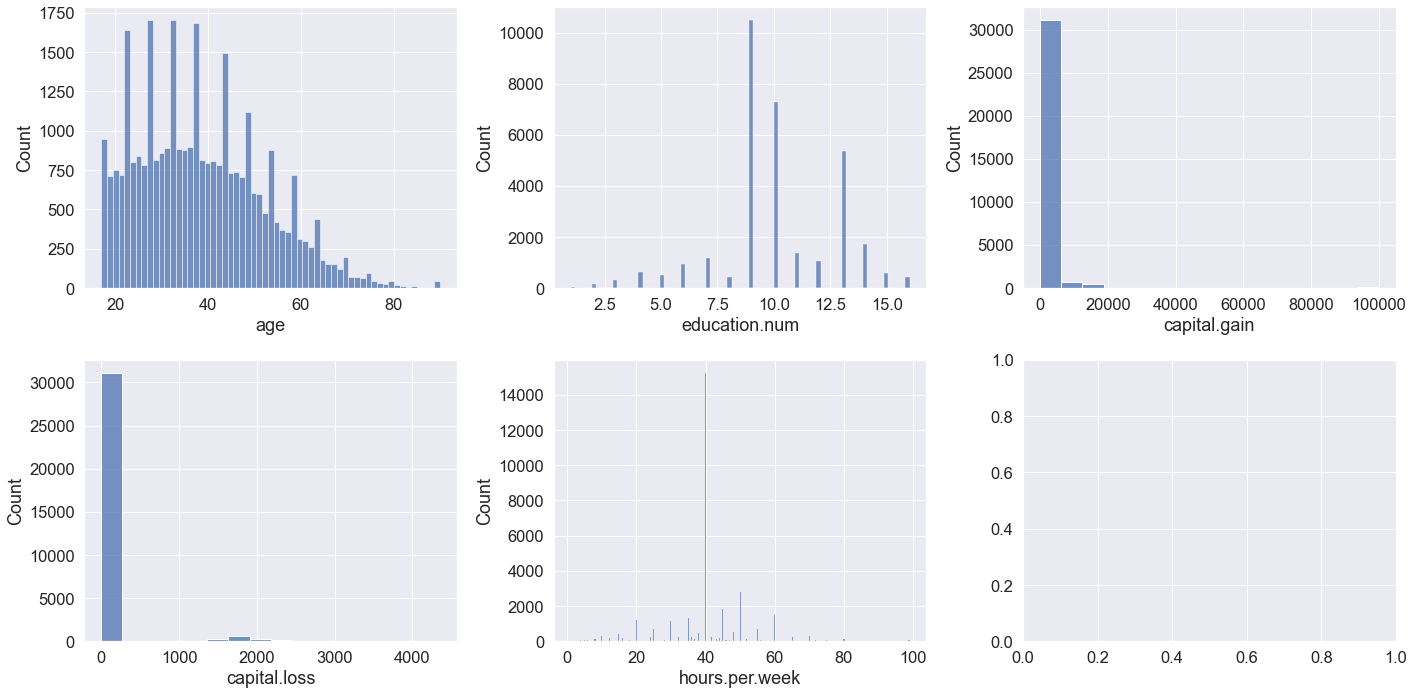

In [808]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
sns.set(font_scale=1.5)

for i in range(len(X_num)):
    ax = sns.histplot(X[X_num[i]], ax=axes[i//3,i%3], element='bars')
plt.tight_layout()
plt.show()

We have a peak in capital gain and capital loss here. It is worth taking some time to analyze these two variables in relation to our classes:

In [684]:
print('capital.gain summary:')
print(X['capital.gain'].value_counts())
print('------------------')
print('capital.loss summary:')
print(X['capital.loss'].value_counts())

capital.gain summary:
0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital.gain, Length: 119, dtype: int64
------------------
capital.loss summary:
0       31041
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital.loss, Length: 92, dtype: int64


We see that the vast majority of our samples have 0 capital.gain or capital.loss, which indicates some benefit from simply dropping this feature in order to reduce dimentionality. However, we could create a variable called 'capital.net', which is simply defined as the difference between capital.gain and capital.loss. This way we still shorten dimentionality, but we don't loose all the information about the feature.

In [685]:
X['capital.net'] = X['capital.gain'] - X['capital.loss']
X = X.drop(['capital.gain', 'capital.loss'], axis=1)

We also have some abnormal peaks in the 'age' feature. The only reason I could imagine for this is rounding off close ages. There is not much we can do about it though.

## Handling categorical data

Now let's see how our categorical data is distributed

No handles with labels found to put in legend.


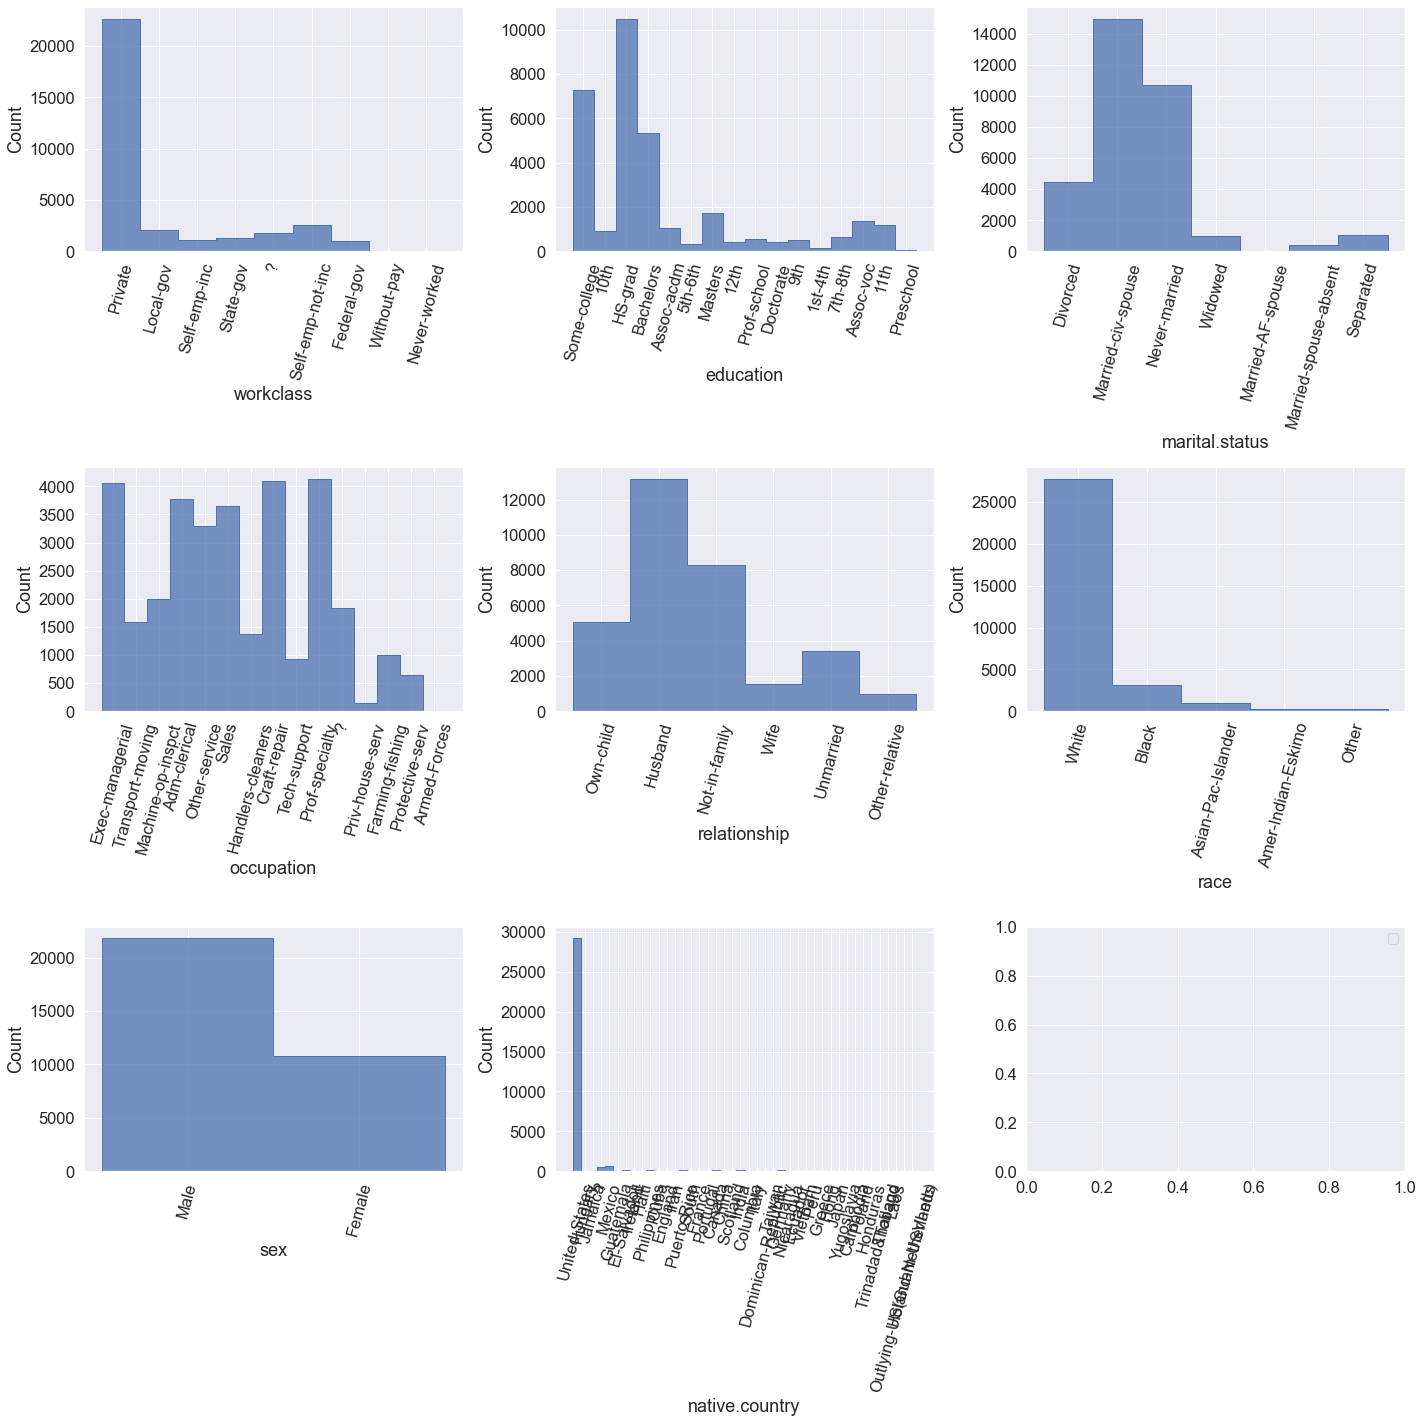

In [686]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
sns.set(font_scale=1.2)

for i in range(len(X_cat)):
    ax = sns.histplot(X[X_cat[i]], ax=axes[i//3,i%3], element='step')
    ax.tick_params(axis='x', labelrotation=75)
plt.legend()
plt.tight_layout()
plt.show()

We have some insights from these plots:
- The variables 'education.num' and 'education' are clearly redundant variables. Since 'education.num' is already numerical, I will drop 'education' and leave the other. Besides that, the variable 'education.num' strongly suggests it is a form of encoding the 'education' variable.
- The vast majority of samples are US citizens. We have to deal with this.

I handled these matters in the order:

In [687]:
#dropping column 'education'
X = X.drop('education', axis=1)

As per 'native.country', let's investigate it a little further:

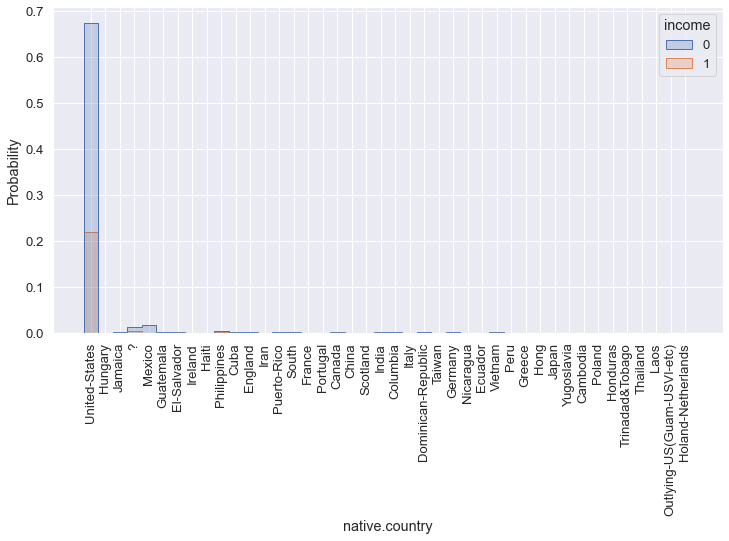

In [688]:
plt.figure(figsize=(12,6))
ax = sns.histplot(x=X['native.country'], hue=y, element='step', stat='probability')
ax.tick_params(axis='x', labelrotation=90)

Indeed, most of the nationalities are not representative enough for us to be super fine when it comes to representation. The best way to deal with this is by grouping them in:
- United-States
- Mexico
- Others

In [689]:
#grouping all the countries that are different from US, Mexico, and '?' in a new category called 'Others'
def countries_unite(country):
    if country !='United-States' and country != 'Mexico' and country != '?':
        country = 'Others'
    return country

X['native.country'] = X['native.country'].apply(countries_unite)

I decided to keep the '?' value, since it could have some correlation between income and not wanting/knowing the native country. We know from a geopolitical point of view that the United States shelter many people comming from foreign countries looking for better opportunities, and sometimes these people are not legaly registered. This social situation could yield bad working conditions and lower wages.

### Handling 'marital.status' feature

Taking a look at the values of the 'marital.status' feature we see that:

In [690]:
print('Values of marital.status feature:')
print(X['marital.status'].unique())

Values of marital.status feature:
['Divorced' 'Married-civ-spouse' 'Never-married' 'Widowed'
 'Married-AF-spouse' 'Married-spouse-absent' 'Separated']


Something noticed in the categorical data is that in many cases, two values of some feature are pretty similiar in meaning, such as: 'divorced' and 'separated'. Grouping such values together will help us later when we do One Hot Encoding in these categorical data.

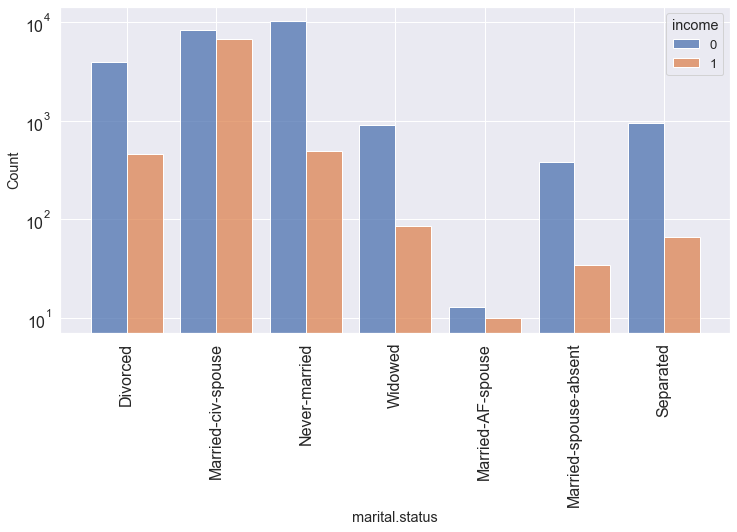

In [691]:
plt.figure(figsize=(12,6))
sns.histplot(x = X['marital.status'], hue=y, multiple="dodge", 
             stat = 'count', shrink = 0.8, common_norm=False, log_scale=[False,True])
plt.xticks(fontsize=16,rotation = 90)
plt.yticks(fontsize=16)
#plt.legend()
plt.show()

In [692]:
# grouping together some similar values in the marital.status feature
def group_marital(status):
    if status == 'Married-AF-spouse' or status == 'Married-civ-spouse':
        return 'Married'

    if status == 'Divorced' or status == 'Separated':
        return 'Divorced'
    
    else:
        return status
        
X['marital.status'] = X['marital.status'].apply(group_marital)

I will choose to maintain the '?' value here, since it may have some information for the classifier.

### A brief discussion about 'race' and 'sex' features

These two features were the subject of many discussions between me and some friends. What if our algorithm is discriminatory? In some sense we actually want to discriminate people, in the most crude sense of the word, since we want to classify people by their income. 

After hours of discussion and philosophical debates whether or not to put these features, I decided to include these with two conditions:
- I should tackle this matter here (as I am doing right now)
- I will study the behavior of the classifier with and without these features.

So now I will open two branches: one where I use this data, and another where I don't.

## Normalization

The knn-classifier is based in distance between features. Therefore, it is crucial that we normalize our data. For this, the normalization form is

$$z = \frac{x - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the variance.

In [693]:
#re-defining the numerical features after all the processing
X_num = [i for i in X.columns[:-1] if X.dtypes[i] == 'int64' or X.dtypes[i] == 'float64']
scaler = preprocessing.StandardScaler()
X[X_num] = scaler.fit_transform(X[X_num])

If we use the 'sex' feature, we can encode it, since we only have two possible values. This reduces dimensionality when we use one hot encoding.

In [694]:
def sex_encode(sex):
    if sex=='Male':
        return 1
    if sex=='Female':
        return 0

X['sex'] = X['sex'].apply(sex_encode)

## Applying One Hot Encoding for categorical features:

Since we don't have as much as categorical data as before the data-prep, and many values were grouped together, we can use One Hot Encoding for the remaining categorical features.

In [695]:
X_cat = [i for i in X.columns if X.dtypes[i] == 'object'] #updating our categorical features
ohe = pd.get_dummies(X[X_cat]) #creating one-hot-encoded dataframe for our categorical features
X = pd.concat([X, ohe], axis=1) #concatenating the above dataframe with our main dataframe
X = X.drop(X[X_cat], axis=1) #dropping the original categorical features

## Correlations

One last thing we can do before we can implement our KNN classifier is to plot a correlation matrix for the whole dataset to check for undesirable correlations.

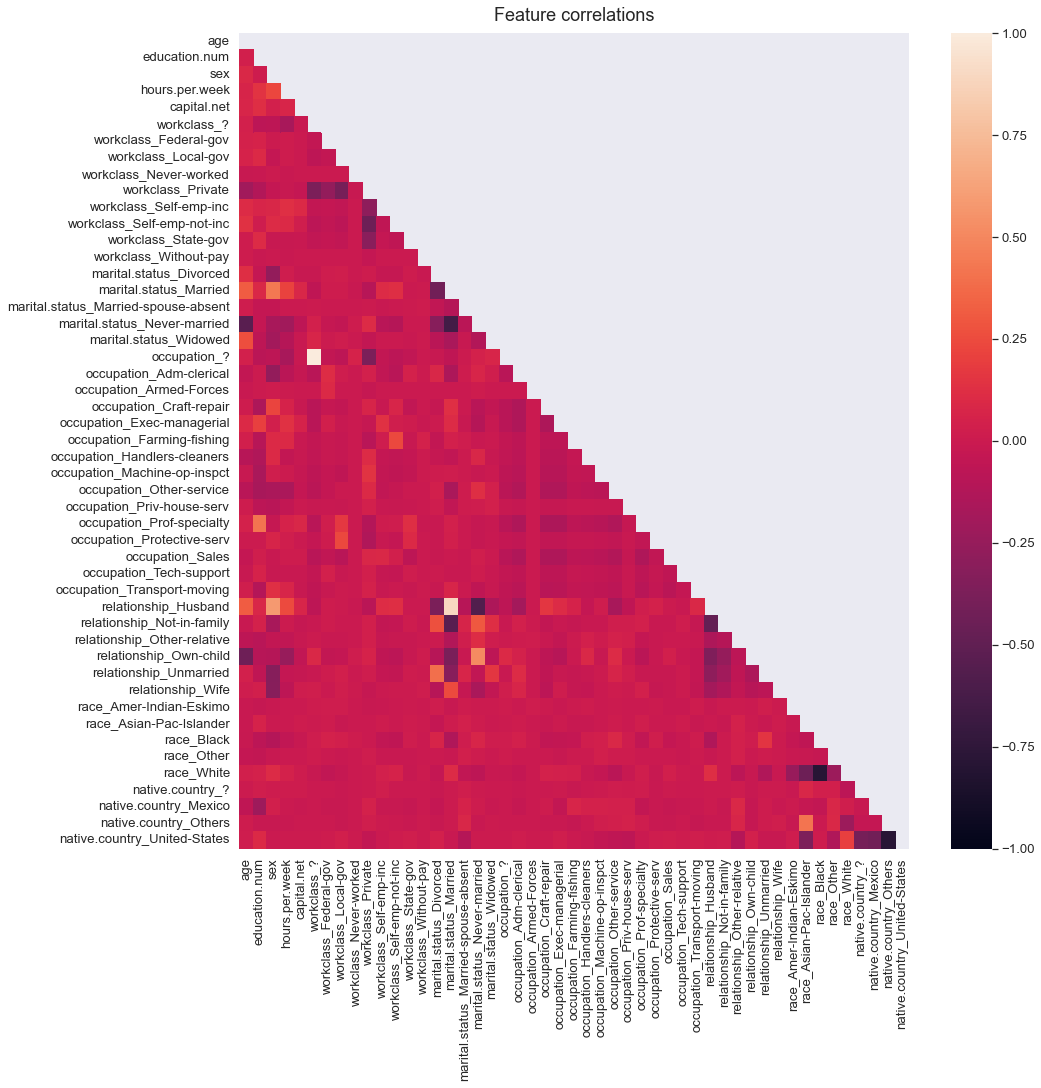

In [696]:
plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
heatmap = sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, annot=False)
heatmap.set_title('Feature correlations', fontdict={'fontsize':18}, pad=12)
plt.show()

As expected, the vast majority of the features present no correlation two-by-two. There are some strong correlations, such as 'race' = 'White' has a strong inverse correlation with 'race' = 'Black', as we could suspect. These correlations are not compromising though.

# Implementation of the classifier

As discussed earlier, I will open two branches: one classifier will be trained with the with 'race' and 'sex' features and the other one without them. For both of them, I used a kNN classifier, with a k-parameter varying from 1 to 40, and using 3-fold cross validation to estimate the accuracy of them.

## Using 'sex' and 'race' features

In [725]:
k_neighbors = np.arange(1, 41, 1, dtype=np.int)

train_scores, test_scores = model_selection.validation_curve(KNeighborsClassifier(),
                                                            X, y,
                                                            param_name='n_neighbors',
                                                            param_range = k_neighbors,
                                                            cv=3)

Bellow I plotted the mean accuracy obtained for each value of k.

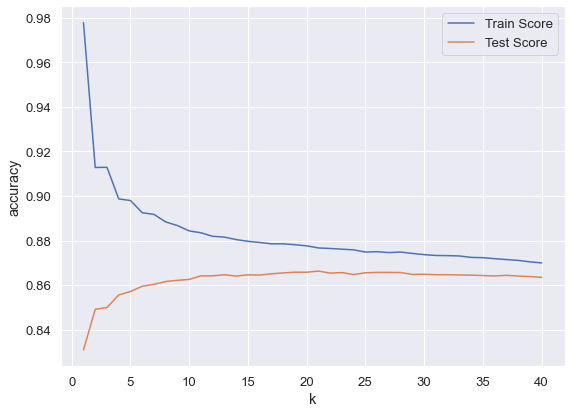

In [726]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0,0,1,1])

ax1.plot(k_neighbors, np.mean(train_scores, axis=1), label='Train Score')
ax1.plot(k_neighbors, np.mean(test_scores, axis=1), label='Test Score')
ax1.legend()
ax1.set_xlabel('k')
ax1.set_ylabel('accuracy')
plt.show()

Next I picked the biggest accuracy:

In [727]:
index_k_max = np.argmax(np.mean(test_scores, axis=1))

print('k with maximum accuracy:',k_neighbors[index_k_max])
print('Accuracy of such k:', np.mean(test_scores[index_k_max]))

k with maximum accuracy: 21
Accuracy of such k: 0.8662776938462914


Now I divided our original train set into two subjacent train and test sets, trained the algorith with the train data and using the best value of k. Then I checked the accuracy score within the test set.

In [797]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state = 0)

knn = KNeighborsClassifier(n_neighbors = k_neighbors[index_k_max])
knn.fit(X_train, y_train)
print('accuracy using test set:',knn.score(X_test, y_test))

accuracy using test set: 0.8637592137592137


## Without 'sex' and 'race' features

Before implementing the classifier I dropped the columns related to race and sex.

In [729]:
X_1 = X.drop(['race_Black', 
            'race_White', 
            'race_Other', 
            'race_Amer-Indian-Eskimo',
            'race_Asian-Pac-Islander', 
            'sex'], axis=1)

The same procedure will be conduced:

In [730]:
k_neighbors = np.arange(1, 41, 1, dtype=np.int)

train_scores_1, test_scores_1 = model_selection.validation_curve(KNeighborsClassifier(),
                                                            X_1, y,
                                                            param_name='n_neighbors',
                                                            param_range = k_neighbors,
                                                            cv=3)

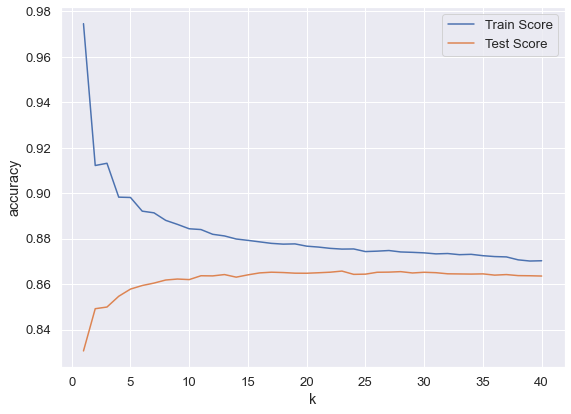

In [731]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0,0,1,1])

ax1.plot(k_neighbors, np.mean(train_scores_1, axis=1), label='Train Score')
ax1.plot(k_neighbors, np.mean(test_scores_1, axis=1), label='Test Score')
ax1.legend()
ax1.set_xlabel('k')
ax1.set_ylabel('accuracy')
plt.show()

In [732]:
index_k_max_1 = np.argmax(np.mean(test_scores_1, axis=1))

print('k with maximum accuracy:',k_neighbors[index_k_max_1])
print('Accuracy of such k:', np.mean(test_scores_1[index_k_max_1]))

k with maximum accuracy: 23
Accuracy of such k: 0.8657248598033478


In [798]:
X_train_1, X_test_1, y_train, y_test = model_selection.train_test_split(X_1, y, random_state = 0)

knn_1 = KNeighborsClassifier(n_neighbors = k_neighbors[index_k_max_1])
knn_1.fit(X_train_1, y_train)
print('accuracy using test set:',knn_1.score(X_test_1, y_test))

accuracy using test set: 0.864004914004914


# Evaluation of the classifiers

As a final step, it would be good to see the confusion matrix of our classifier, as well as the F1 metric.

## With 'race' and 'sex' features

In [799]:
y_pred = knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = (conf_matrix[1,1])/(conf_matrix[1,1] + conf_matrix[0,1])
recall = (conf_matrix[1,1])/(conf_matrix[1,1] + conf_matrix[1,0])
f1 = 2*((precision*recall)/(precision + recall))
print('Confusion matrix:')
print(conf_matrix)
print('precision:', precision)
print('recall:', recall)
print('F1-score:', f1)

Confusion matrix:
[[5671  415]
 [ 694 1360]]
precision: 0.7661971830985915
recall: 0.6621226874391432
F1-score: 0.7103682423609298


## Without 'race' and 'sex' features

In [800]:
y_pred_1 = knn_1.predict(X_test_1)
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
precision_1 = (conf_matrix_1[1,1])/(conf_matrix_1[1,1] + conf_matrix_1[0,1])
recall_1 = (conf_matrix_1[1,1])/(conf_matrix_1[1,1] + conf_matrix_1[1,0])
f1_1 = 2*((precision_1*recall_1)/(precision_1 + recall_1))
print('Confusion matrix:')
print(conf_matrix_1)
print('precision:', precision_1)
print('recall:', recall_1)
print('F1-score:', f1_1)

Confusion matrix:
[[5670  416]
 [ 691 1363]]
precision: 0.7661607644744238
recall: 0.6635832521908471
F1-score: 0.7111922775893557


# Testing on the real test dataset

We need to apply the same treatment as we did before.

## With 'sex' and 'race' features

In [784]:
df_test = pd.read_csv('test_data.csv')

In [785]:
#dropping columns that we don't need
df_test = df_test.drop(['Id', 'fnlwgt', 'education'], axis=1)

#creating the new variable capital.net
df_test['capital.net'] = df_test['capital.gain'] - df_test['capital.loss']

#dropping 'capital.gain' and 'capital.loss' features

df_test = df_test.drop(['capital.gain', 'capital.loss'], axis=1)

#grouping countries
df_test['native.country'] = df_test['native.country'].apply(countries_unite)

#grouping marital status
df_test['marital.status'] = df_test['marital.status'].apply(group_marital)

#defining numerical data so we can normalize them
df_test_num = [i for i in df_test.columns if df_test.dtypes[i] == 'int64' or df_test.dtypes[i] == 'float64']
scaler = preprocessing.StandardScaler()
df_test[df_test_num] = scaler.fit_transform(df_test[df_test_num])

#encoding 'sex' feature
df_test['sex'] = df_test['sex'].apply(sex_encode)

#defining categorical data so we can apply one hot encoding
df_test_cat = [i for i in df_test.columns if df_test.dtypes[i] == 'object'] #updating our categorical features
ohe = pd.get_dummies(df_test[df_test_cat]) #creating one-hot-encoded dataframe for our categorical features
df_test = pd.concat([df_test, ohe], axis=1) #concatenating the above dataframe with our main dataframe
df_test = df_test.drop(df_test[df_test_cat], axis=1) #dropping the original categorical features

In [786]:
pred_vec = pd.Series(knn.predict(df_test))

Now we decode this vector, applying a function that returns:
- '<=50K' if 0,
- '>50K' if 1

In [788]:
def decode(value):
    if value == 0:
        return '<=50K'
    else:
        return '>50K'

pred_vec_decoded = pred_vec.apply(decode)

## No 'sex' and 'race' features

In [791]:
df_test = pd.read_csv('test_data.csv')

The next cell sumarizes every manipulation we did with our database:

In [792]:
#dropping columns that we don't need
df_test = df_test.drop(['Id', 'fnlwgt', 'education', 'sex', 'race'], axis=1)

#creating the new variable capital.net
df_test['capital.net'] = df_test['capital.gain'] - df_test['capital.loss']

#dropping 'capital.gain' and 'capital.loss' features

df_test = df_test.drop(['capital.gain', 'capital.loss'], axis=1)

#grouping countries
df_test['native.country'] = df_test['native.country'].apply(countries_unite)

#grouping marital status
df_test['marital.status'] = df_test['marital.status'].apply(group_marital)

#defining numerical data so we can normalize them
df_test_num = [i for i in df_test.columns if df_test.dtypes[i] == 'int64' or df_test.dtypes[i] == 'float64']
scaler = preprocessing.StandardScaler()
df_test[df_test_num] = scaler.fit_transform(df_test[df_test_num])

#defining categorical data so we can apply one hot encoding
df_test_cat = [i for i in df_test.columns if df_test.dtypes[i] == 'object'] #updating our categorical features
ohe = pd.get_dummies(df_test[df_test_cat]) #creating one-hot-encoded dataframe for our categorical features
df_test = pd.concat([df_test, ohe], axis=1) #concatenating the above dataframe with our main dataframe
df_test = df_test.drop(df_test[df_test_cat], axis=1) #dropping the original categorical features

In [796]:
pred_vec1 = pd.Series(knn_1.predict(df_test))
pred_vec_decoded1 = pred_vec1.apply(decode)

In [823]:
pred_vec_decoded1.to_csv('prediction.csv', header=['income'], index_label=['Id'], sep=',')